### Dataset Split

In [ ]:
import torch
import cv2
from tqdm import tqdm_notebook as tqdm
import matplotlib as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
def read_file(path):
    meta = pd.read_csv(path, index_col=False)
    return meta

# meta = read_file(file_path)

In [ ]:
meta  = read_file('../data/Aug2.0_Meta_all.csv')

In [ ]:
root = '../data/Aug2.0/'
file_path = '../data/new_augmented.csv'

In [ ]:
meta['new_paths'] = root + meta['image_id']+'.jpg'
meta

In [ ]:
X, y = meta.iloc[:,[0,1,3,4,5,6,7]], meta.iloc[:,2]

# train/test Split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, stratify=y)
print(f"train: {len(xtrain)}, test: {len(xtest)} ")

# Concat X/y for train/test
xtrain.insert(loc = 2, column = 'dx', value = ytrain)
xtest.insert(loc= 2 , column = 'dx', value = ytest )

# Writing to CSV
xtest.to_csv('../data/Aug2.0_test.csv', index=False)
xtrain.to_csv('../data/Aug2.0_train.csv', index=False)

xtrain['dx'].value_counts()

In [ ]:
def Check_Paths(file):
    meta = pd.read_csv(file)
    Files_NotFound = []
    for i, r in meta.iterrows():
        if os.path.exists(meta.iloc[i, -1]):
            continue
        else:
            Files_NotFound.append(meta.iloc[i, -1])
    return Files_NotFound

nf = Check_Paths('../data/Aug2.0_test.csv')
len(nf)        

### Augmentation

In [ ]:
path = '../data/HAM10k/HAM10000_metadata.csv'
def read_file(path):
    meta = pd.read_csv(path, index_col=False)
    return meta

df = read_file(path)
desc = df['dx'].value_counts()
desc

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm_notebook as tqdm

gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, 
                        zoom_range= 0.1, horizontal_flip= True, rescale=2)

In [ ]:
aug_dir = 'Aug2.0'
basedir = '../data/HAM10k/HAM10000_images/'
print(f"Folder Exists..") if os.path.exists('../data/'+aug_dir) else os.mkdir('../data/'+aug_dir)
save_dir = '../data/'+aug_dir+'/'
total_generated_images = 0
for key in desc.keys():
    print(key, desc[key])
    ratio = int(desc['nv']/ desc[key])
    print('Ratio to NV: ', ratio)
    print('Augmenataions Needed/Image', ratio)
    total_generated_images += ratio
    all_images = df[df['dx'] == key]['image_id'].values
    if(key == 'nv'):
        continue
    printonce= True
    # iterate over all images augment them, save them and insert them in our metadata frame
    for image_ in tqdm(all_images):
        if(len(df[df['dx'] == key]) > len(df[df['dx'] == 'nv'])):
            if printonce:
                print(key, 'datapoints = ', len(df[df['dx'] == key]), 'reached above nv skipping more augmentations..')
                printonce = False
            continue
    
        image_path =  basedir + image_ + '.jpg'
        image = load_img(image_path)
        image = np.expand_dims(img_to_array(image), axis= 0)
        generated = gen.flow(image)
        row = df[df['image_id'] == image_]
        dict_for_df = {
            'lesion_id':row.lesion_id.values[0], 'image_id':row.image_id.values[0], 
            'dx':row.dx.values[0], 'dx_type':row.dx_type.values[0] ,
            'age':row.age.values[0], 'sex':row.sex.values[0], 'localization':row.localization.values[0] 
        }
       
        for i in range(int(ratio)):
            aug_image= next(generated).astype(np.uint8)
            # save this image with an underscore
            # add this to metadata dataframe
            image_name= dict_for_df['image_id'] + '_' + str(i)
            fname = image_name.split('_')
            modify_name = fname[0]+'_'+fname[1]+'_'+fname[-1]
            dict_for_df['image_id'] = modify_name
            df = df.append(dict_for_df, ignore_index=True)
            plt.imsave(save_dir + modify_name + '.jpg', aug_image[0])
    
print(f"Total Images generated : {(total_generated_images)}")
print(f"Consolidating All Images...")

# rename the images
print(f"Renaming files to desired format...")
for file in tqdm(os.listdir(save_dir)):
    filename = file.split('_')
    renamed = filename[0]+'_'+filename[1]+'_'+filename[-1]
    os.rename(save_dir+file, save_dir+renamed)

#  Copy the images
for file in tqdm(os.listdir(basedir)):
    shutil.copy(basedir+file, save_dir)
    
print(f"Total Images: {len(os.listdir(save_dir))}")
# Modify and save the meta file
try:
    new_meta_file = f'{aug_dir}_Meta_all.csv'
    # df['new_image_id'] = df['image_id'].split()
    df.to_csv('../data/'+new_meta_file, index=False)
    print(f"New Meta File : {new_meta_file}")
except:
    print(f"FileError :: Error occured during meta file saving...")

In [ ]:
!curl -L https://github.com/pablonm3/gan_skin_cancer/blob/master/skin_cancer_data_gan.ipynb -o test.ipynb

In [ ]:
#  Renaming he files
root = '../data/Aug2.0/'
for file in os.listdir('../data/Aug2.0/'):
    filename = file.split('_')
    if len(filename) > 2:
        renamed = filename[0]+'_'+filename[-1]
    else:
        renamed = file
    os.rename(root + file, root + str(renamed))

In [ ]:
df.to_csv('../data/Aug2.0_Meta_All.csv', index=False)

In [ ]:
import numpy as np
arr = np.array([])

In [1]:
from os import path
import sys
sys.path.append(path.abspath('../src/'))

from dataset import SkinCancer

C:\Users\mjan2021\Documents\GitHub\SkinCancer\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


In [3]:
n_epochs=5
batch_size = 64
lr=0.0002
b1=0.5
b2=0.999
n_cpu=8
latent_dim=100
n_classes=7
img_size=32
channels=1
sample_interval=400
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, latent_dim)

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label


In [7]:
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if device == 'cuda':
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    auxiliary_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)


Discriminator(
  (conv_blocks): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ad

In [8]:

# Configure data loader
# os.makedirs("../data/mnist", exist_ok=True)
# dataloader = torch.utils.data.DataLoader(
#     datasets.MNIST(
#         "../../data/mnist",
#         train=True,
#         download=True,
#         transform=transforms.Compose(
#             [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
#         ),
#     ),
#     batch_size=opt.batch_size,
#     shuffle=True,
# )


# Skin Cancer Dataset
data_dir = '../data/HAM10k/HAM10000_images/'
train_data = SkinCancer(data_dir, '../data/minority_train.csv', transform=None)
dataset_size = len(train_data)    
test_data = SkinCancer(data_dir, '../data/minority_test.csv',transform=None)
classes=np.unique(train_data.classes)

In [9]:
dataloader = torch.utils.data.DataLoader(train_data, batch_size=16)

In [10]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if device == 'cuda' else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if device == 'cuda' else torch.LongTensor

In [11]:

def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

In [ ]:
img, lbl = next(iter(dataloader))

In [ ]:
img.to(device)

In [ ]:
lbl.to(device)

In [ ]:
img,labels = next(iter(dataloader))
    

In [ ]:
imgs

In [14]:
len(dataloader) * 16

2656

In [15]:
165*16

2640

In [22]:
# ----------
#  Training
# ----------
device='cuda'
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        
        if i<165:
        
            batch_size = 16
            imgs = imgs.to(device)
            labels = labels.to(device)

            # Adversarial ground truths
            valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
            fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

            # Configure input
            # real_imgs = Variable(imgs.type(FloatTensor))
            # labels = Variable(labels.type(LongTensor))

            real_imgs = imgs
            labels = LongTensor(labels)
            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Sample noise and labels as generator input
            z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
            gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

            # Generate a batch of images
            gen_imgs = generator(z, gen_labels)

            # Loss measures generator's ability to fool the discriminator
            validity, pred_label = discriminator(gen_imgs)
            g_loss = 0.5 * (adversarial_loss(validity, valid) + auxiliary_loss(pred_label, gen_labels))

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Loss for real images
            real_pred, real_aux = discriminator(real_imgs)
            d_real_loss = (adversarial_loss(real_pred, valid) + auxiliary_loss(real_aux, labels)) / 2

            # Loss for fake images
            fake_pred, fake_aux = discriminator(gen_imgs.detach())
            d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2

            # Calculate discriminator accuracy
            pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
            gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
            d_acc = np.mean(np.argmax(pred, axis=1) == gt)

            d_loss.backward()
            optimizer_D.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %d%%] [G loss: %f]"
                % (epoch, n_epochs, i, len(dataloader), d_loss.item(), 100 * d_acc, g_loss.item())
            )
        # batches_done = epoch * len(dataloader) + i
        # if batches_done % sample_interval == 0:
        #     sample_image(n_row=10, batches_done=batches_done)


[Epoch 0/5] [Batch 0/166] [D loss: 0.835387, acc: 65%] [G loss: 2.860200]
[Epoch 0/5] [Batch 1/166] [D loss: 4.439139, acc: 28%] [G loss: 2.220542]
[Epoch 0/5] [Batch 2/166] [D loss: 4.556452, acc: 25%] [G loss: 1.368933]
[Epoch 0/5] [Batch 3/166] [D loss: 3.681585, acc: 34%] [G loss: 2.087445]
[Epoch 0/5] [Batch 4/166] [D loss: 3.828504, acc: 28%] [G loss: 1.206982]
[Epoch 0/5] [Batch 5/166] [D loss: 2.969157, acc: 43%] [G loss: 1.233605]
[Epoch 0/5] [Batch 6/166] [D loss: 3.227779, acc: 37%] [G loss: 1.267979]
[Epoch 0/5] [Batch 7/166] [D loss: 3.412123, acc: 50%] [G loss: 1.790952]
[Epoch 0/5] [Batch 8/166] [D loss: 3.317733, acc: 34%] [G loss: 0.994611]
[Epoch 0/5] [Batch 9/166] [D loss: 3.657559, acc: 37%] [G loss: 1.188053]
[Epoch 0/5] [Batch 10/166] [D loss: 3.330030, acc: 40%] [G loss: 1.999264]
[Epoch 0/5] [Batch 11/166] [D loss: 2.563823, acc: 31%] [G loss: 1.090088]
[Epoch 0/5] [Batch 12/166] [D loss: 2.558918, acc: 43%] [G loss: 1.368822]
[Epoch 0/5] [Batch 13/166] [D loss:

In [41]:
gen_labels[0]

tensor(3, device='cuda:0')

In [23]:
gen_imgs = generator(z, gen_labels)

In [24]:
gen_imgs.shape

torch.Size([16, 1, 32, 32])

In [25]:
im = gen_imgs[0]

In [28]:
import matplotlib.pyplot as plt

In [33]:
imm = im.detach().cpu()

In [34]:
imm.shape

torch.Size([1, 32, 32])

In [39]:
imm.squeeze(0).shape

torch.Size([32, 32])

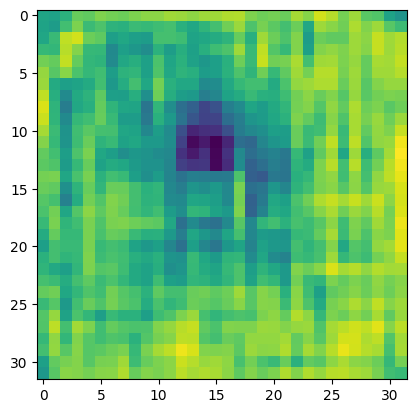

In [40]:
plt.imshow(imm.squeeze().numpy())